# Import all dependencies 

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Import packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import requests
# !pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import sys

# !pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
import segmentation_models as sm
from keras_segmentation.models import segnet
from tensorflow.keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


/opt/anaconda3/envs/deforestation/lib/python3.9/site-packages/imageio/core/util.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Funtions to evaluate the model 

In [2]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [3]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


#Ensures that input has batch dimentions 
def _prepare_input(image):
    """
    Ensures image has shape (1, H, W, C).
    """
    if image.ndim == 3:
        # (H, W, C) to (1, H, W, C)
        return np.expand_dims(image, axis=0)
    return image  # already batched


#Calculate the Accuracy score for the model
def score_eval(model, images, masks):
    scores = []

    for i in range(len(images)):
        x = _prepare_input(images[i])               # shape (1,512,512,4)
        pred = model.predict(x)[0]                 # shape (512,512,1)
        pred = np.round(pred).astype(int).flatten()

        true = masks[i].flatten().astype(int)

        scores.append(accuracy_score(true, pred))

    return scores


#Calculate the Precision score for the model 
def precision_eval(model, images, masks):
    scores = []

    for i in range(len(images)):
        x = _prepare_input(images[i])
        pred = model.predict(x)[0]
        pred = np.round(pred).astype(int).flatten()

        true = masks[i].flatten().astype(int)

        scores.append(
            precision_score(true, pred, average='weighted', zero_division=0)
        )

    return scores

#calculate the recall score for the model 
def recall_eval(model, images, masks):
    scores = []

    for i in range(len(images)):
        x = _prepare_input(images[i])
        pred = model.predict(x)[0]
        pred = np.round(pred).astype(int).flatten()

        true = masks[i].flatten().astype(int)

        scores.append(
            recall_score(true, pred, average='weighted', zero_division=0)
        )

    return scores


#calculate the F1 score for the model 
def f1_score_eval(model, images, masks):

    precision_scores = precision_eval(model, images, masks)
    recall_scores    = recall_eval(model, images, masks)

    prec = np.mean(precision_scores)
    rec  = np.mean(recall_scores)

    if prec + rec == 0:
        return 0.0

    return 2 * (prec * rec) / (prec + rec)


#calculate F1 using previous pression and recall functions 
def f1_score_eval_basic(precision_scores, recall_scores):

    prec = np.mean(precision_scores)
    rec  = np.mean(recall_scores)

    if prec + rec == 0:
        return 0.0

    return 2 * (prec * rec) / (prec + rec)


#produce a bianry mask from prediction 
def produce_mask(image):
    return np.round(image).astype(int)


# Download the preprocessed data 

In [5]:
#Load teh cameroon dataset 
import numpy as np
import os
from PIL import Image

base_dir = "ChosenContext/Cameroon/preprocessing/Cameroon/dataset_split"


def normalize(x):
    x = x.astype("float32")

    # Remove NaN or infinity
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    mn, mx = x.min(), x.max()
    if mx - mn < 1e-6:
        return np.zeros_like(x)    # flat tile = safe value

    x = (x - mn) / (mx - mn)
    return x


#load the 4 band images 
def load_images(folder):
    images = []
    fnames = sorted(os.listdir(folder))
    for f in fnames:
        if f.endswith(".npy"):
            arr = np.load(os.path.join(folder, f))  # shape = (512,512,4)
            images.append(normalize(arr))
    return images

# load the ground truth mask 
def load_masks(folder):
    masks = []
    fnames = sorted(os.listdir(folder))
    for f in fnames:
        if f.endswith(".png"):
            m = np.array(Image.open(os.path.join(folder, f)))
            m = (m > 127).astype("float32")       # convert to 0-1
            masks.append(m.reshape(512,512,1)) # shape = (512,512,1)
    return masks

# load train / val / test sets
train_images = load_images(base_dir + "train/images/")
train_masks  = load_masks(base_dir + "train/masks/")

val_images = load_images(base_dir + "val/images/")
val_masks  = load_masks(base_dir + "val/masks/")

test_images = load_images(base_dir + "test/images/")
test_masks  = load_masks(base_dir + "test/masks/")

print("Loaded:")
print("Train:", len(train_images), "images,", len(train_masks), "masks")
print("Val:", len(val_images), "images,", len(val_masks), "masks")
print("Test:", len(test_images), "images,", len(test_masks), "masks")


Loaded:
Train: 41 images, 41 masks
Val: 23 images, 23 masks
Test: 5 images, 5 masks


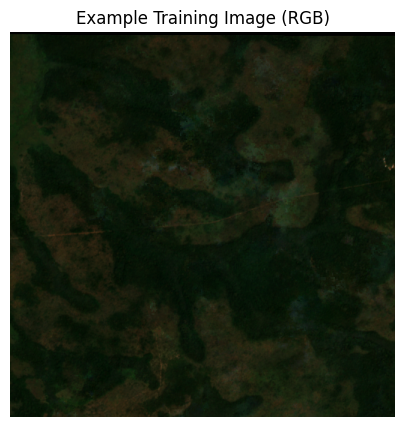

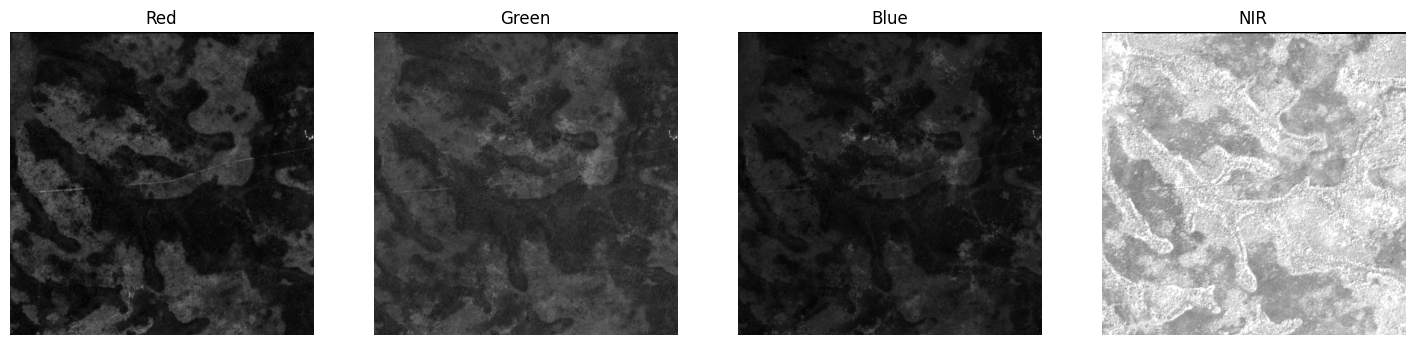

(-0.5, 511.5, 511.5, -0.5)

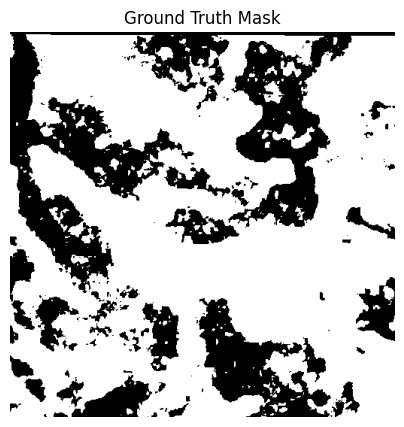

In [6]:

# Show example train image (RGB only)
example = train_images[1]               # (512,512,4)
rgb = example[:, :,0:3]             # take R,G,B channels

plt.figure(figsize=(5,5))
plt.imshow(rgb)
plt.title("Example Training Image (RGB)")
plt.axis("off")

# Show example train image (all 4 band seperately)
example = train_images[1]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
titles = ["Red", "Green", "Blue", "NIR"]

for i in range(4):
    axes[i].imshow(example[:, :, i], cmap="gray")
    axes[i].set_title(titles[i])
    axes[i].axis("off")

plt.show()
#visilause the ground truth mask 
plt.figure(figsize=(5,5))
plt.imshow(train_masks[1].reshape(512,512), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")



In [7]:
# Pre-process data, reshaping and transposing
# Convert lists to numpy arrays for training
train_x = np.stack(train_images)  
train_y = np.stack(train_masks)    

val_x = np.stack(val_images)
val_y = np.stack(val_masks)

test_x = np.stack(test_images)
test_y = np.stack(test_masks)

print("Train set shape:", train_x.shape, train_y.shape)
print("Val set shape:", val_x.shape, val_y.shape)
print("Test set shape:", test_x.shape, test_y.shape)


Train set shape: (41, 512, 512, 4) (41, 512, 512, 1)
Val set shape: (23, 512, 512, 4) (23, 512, 512, 1)
Test set shape: (5, 512, 512, 4) (5, 512, 512, 1)


In [8]:
# Create TensorFlow datasets for training and validation sets
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1)
val_ds   = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(1)
test_ds  = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(1)


# Dataloader and Generator 

In [9]:
import numpy as np
import random
import tensorflow as tf

class trainGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=1, shuffle=True, augment=False):
        self.images = images        # use the already loaded arrays
        self.masks = masks          
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

        # convert masks to binary 0/1 float
        self.masks = (self.masks > 0.5).astype(np.float32)

        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_idx = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = []
        batch_y = []

        for i in batch_idx:
            img = self.images[i].astype(np.float32)

            # ensure image is normalised 
            if img.max() > 1.0:
                img = img / 255.0

            mask = self.masks[i].astype(np.float32)

            if self.augment:
                img, mask = self.apply_augment(img, mask)

            # expand mask channel if needed
            if len(mask.shape) == 2:
                mask = mask[..., None]

            batch_x.append(img)
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

    def apply_augment(self, img, mask):
        # Horizontal flip
        if random.random() < 0.5:
            img = np.flip(img, 1)
            mask = np.flip(mask, 1)

        # Vertical flip
        if random.random() < 0.5:
            img = np.flip(img, 0)
            mask = np.flip(mask, 0)

        return img, mask


In [10]:

# Produce generators for training images

# Stack lists into arrays
t_images = train_x
t_masks  = train_y
v_images = val_x
v_masks  = val_y


train_gen = trainGenerator(
    images=train_x,
    masks=train_y,
    batch_size=1,
    shuffle=True,
    augment=True
)

val_gen = trainGenerator(
    images=val_x,
    masks=val_y,
    batch_size=1,
    shuffle=False,
    augment=False #no augmentation in validation 
)


# The Model : Attention U-Net

In [12]:
# Loss Functions
import tensorflow as tf
import tensorflow.keras.backend as K

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))

    return 1 - (tp + 1e-7) / (tp + alpha * fp + beta * fn + 1e-7)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky_loss(y_true, y_pred)
    return tf.pow(tv, gamma)


def weighted_bce(y_true, y_pred, pos_weight=3.0):
    # Convert sigmoid output back to logits
    eps = 1e-7
    y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
    logits = tf.math.log(y_pred / (1 - y_pred))

    bce = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true,
        logits=logits,
        pos_weight=pos_weight
    )
    return tf.reduce_mean(bce)


def final_loss(y_true, y_pred):
    return weighted_bce(y_true, y_pred, pos_weight=3.0) + focal_tversky_loss(y_true, y_pred)


#  Metrics used to know when to save the model during training 
class IoUMetric(tf.keras.metrics.Metric):
    def __init__(self, name='iou_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.inter = self.add_weight(name='inter', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        inter = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
        self.inter.assign_add(inter)
        self.union.assign_add(union)

    def result(self):
        return (self.inter + 1e-7) / (self.union + 1e-7)

    def reset_state(self):
        self.inter.assign(0.0)
        self.union.assign(0.0)


class F1Metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum(y_pred) - tp
        fn = tf.reduce_sum(y_true) - tp
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        return (2. * self.tp + 1e-7) / (2. * self.tp + self.fp + self.fn + 1e-7)

    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)


# the model building blocks 
def conv_block(x, filters, kernel_size=3, drop_rate=0.2):
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if drop_rate:
        x = Dropout(drop_rate)(x)
    return x


def up_conv(x, filters):
    x = Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


# Attention Gate
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, 1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, padding='same')(g)

    # Resize phi_g to match spatial dims
    if K.int_shape(theta_x)[1] != K.int_shape(phi_g)[1]:
        phi_g = UpSampling2D(size=(K.int_shape(theta_x)[1] // K.int_shape(phi_g)[1],
                                   K.int_shape(theta_x)[2] // K.int_shape(phi_g)[2]),
                             interpolation='bilinear')(phi_g)

    add_xg = Add()([theta_x, phi_g])
    act = Activation('relu')(add_xg)
    psi = Conv2D(1, 1, padding='same')(act)
    psi = Activation('sigmoid')(psi)

    # Resize psi to match input x
    if K.int_shape(psi)[1] != K.int_shape(x)[1]:
        psi = UpSampling2D(size=(K.int_shape(x)[1] // K.int_shape(psi)[1],
                                 K.int_shape(x)[2] // K.int_shape(psi)[2]),
                           interpolation='bilinear')(psi)

    attn = Multiply()([x, psi])
    return attn


# Attention U-Net model 
def AttentionUNet(input_shape=(512,512,4), filter_base=16, drop_rate=0.2):
    inputs = Input(shape=input_shape)

    # encoder
    c1 = conv_block(inputs, filter_base, drop_rate=drop_rate)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, filter_base*2, drop_rate=drop_rate)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, filter_base*4, drop_rate=drop_rate)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, filter_base*8, drop_rate=drop_rate)
    p4 = MaxPooling2D((2,2))(c4)

    # bottleneck
    c5 = conv_block(p4, filter_base*16, drop_rate=drop_rate)

    # decoder
    u4 = up_conv(c5, filter_base*8)
    att4 = attention_gate(c4, u4, inter_channels=filter_base*8)
    d4 = conv_block(Concatenate()([u4, att4]), filter_base*8, drop_rate=drop_rate)

    u3 = up_conv(d4, filter_base*4)
    att3 = attention_gate(c3, u3, inter_channels=filter_base*4)
    d3 = conv_block(Concatenate()([u3, att3]), filter_base*4, drop_rate=drop_rate)

    u2 = up_conv(d3, filter_base*2)
    att2 = attention_gate(c2, u2, inter_channels=filter_base*2)
    d2 = conv_block(Concatenate()([u2, att2]), filter_base*2, drop_rate=drop_rate)

    u1 = up_conv(d2, filter_base)
    att1 = attention_gate(c1, u1, inter_channels=filter_base)
    d1 = conv_block(Concatenate()([u1, att1]), filter_base, drop_rate=drop_rate)

    outputs = Conv2D(1, 1, activation='sigmoid')(d1)

    return Model(inputs, outputs)


#Create and compile the model
model = AttentionUNet(input_shape=(512,512,4), filter_base=16)

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=final_loss,      
    metrics=[IoUMetric(), F1Metric()]
)
#print the model layers and number of parameters 
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 4)]        0         []                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 512, 512, 16)         592       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 512, 512, 16)         64        ['conv2d_31[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_30 (Activation)  (None, 512, 512, 16)         0         ['batch_normalization_22

# Train the model 

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger

checkpoint = ModelCheckpoint('unet_attention_cameroon_best.keras',
                             monitor='val_f1_score',    # monitor the f1 metric
                             mode='max',
                             save_best_only=True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_f1_score', mode='max', patience=12, restore_best_weights=True, verbose=1)
csv_logger = CSVLogger('training_attention_paper4b.csv', append=True)
batch_size = 1
steps_per_epoch = len(t_images)    
validation_steps = len(v_images)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=60,
    callbacks=[checkpoint, reduce_lr, early_stop, csv_logger],
    verbose=1
)


Epoch 1/60
41/41 [==============================] - ETA: 0s - loss: 1.6675 - iou_score: 0.8112 - f1_score: 0.8957  
Epoch 1: val_f1_score improved from -inf to 0.92194, saving model to unet_attention_cameroon_best.keras
41/41 [==============================] - 26s 585ms/step - loss: 1.6675 - iou_score: 0.8112 - f1_score: 0.8957 - val_loss: 1.7508 - val_iou_score: 0.8552 - val_f1_score: 0.9219 - lr: 5.0000e-04
Epoch 2/60
41/41 [==============================] - ETA: 0s - loss: 1.1781 - iou_score: 0.9148 - f1_score: 0.9555 
Epoch 2: val_f1_score improved from 0.92194 to 0.92472, saving model to unet_attention_cameroon_best.keras
41/41 [==============================] - 24s 581ms/step - loss: 1.1781 - iou_score: 0.9148 - f1_score: 0.9555 - val_loss: 1.7085 - val_iou_score: 0.8600 - val_f1_score: 0.9247 - lr: 5.0000e-04
Epoch 3/60
41/41 [==============================] - ETA: 0s - loss: 0.9817 - iou_score: 0.9228 - f1_score: 0.9598 
Epoch 3: val_f1_score did not improve from 0.92472
41/41 

In [14]:
# Save model history
np.save('unet-attention-4d-history.npy', model.history.history)

1/1 [==============================] - 0s 128ms/step


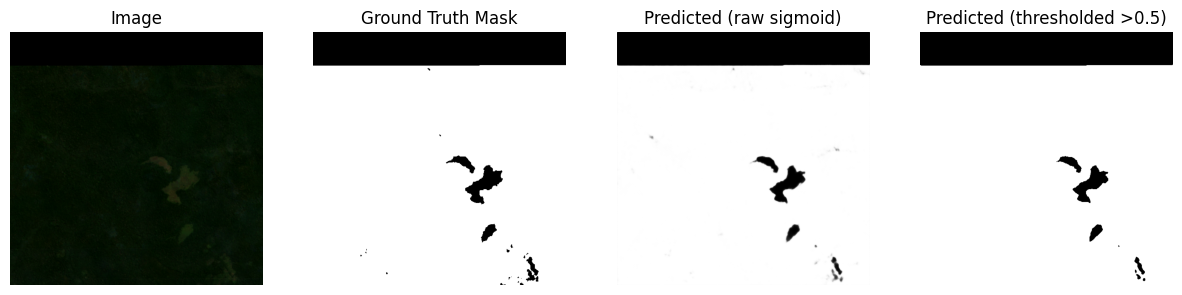

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def show_prediction(model, generator):
    """
    Pulls one sample from the generator and shows:
    - Original image (RGB)
    - Ground truth mask (binary)
    - Predicted mask (sigmoid output)
    - Predicted mask thresholded at 0.5
    """

    # get a batch
    img, mask = next(iter(generator))

    # model prediction
    pred = model.predict(img)[0]      # (512,512,1)
    pred_bin = (pred > 0.5).astype(np.float32)

    # squeeze for plotting
    mask = mask[0].squeeze()
    pred = pred.squeeze()
    pred_bin = pred_bin.squeeze()

    # plot teh images 
    plt.figure(figsize=(15,5))

    plt.subplot(1,4,1)
    plt.imshow(img[0][...,:3])  # show RGB only
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted (raw sigmoid)")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(pred_bin, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted (thresholded >0.5)")
    plt.axis("off")

    plt.show()
show_prediction(model, train_gen)


# Import model and compute evaluation metrics 

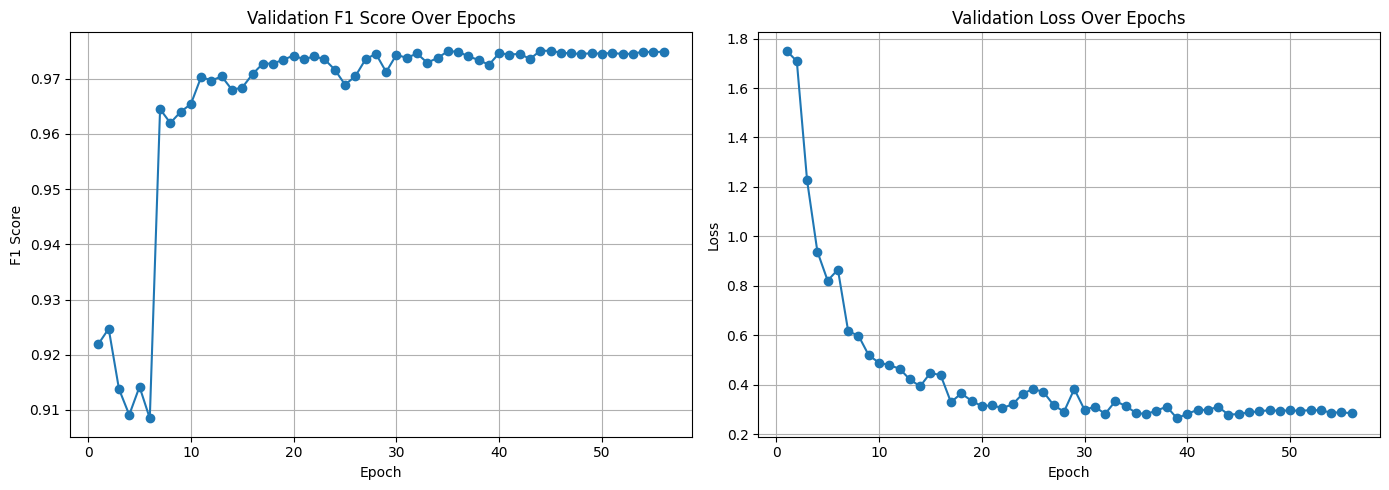

In [16]:
import matplotlib.pyplot as plt

def plot_val_metrics(history):
    """
    Plots validation F1-score and validation loss from a Keras history object.
    """

    val_f1 = history.history.get("val_f1_score", None)
    val_loss = history.history.get("val_loss", None)
    #make sure the value are saved in history 
    if val_f1 is None:
        raise ValueError("No 'val_f1_score' found in history. Make sure F1Metric() is in model.compile().")

    if val_loss is None:
        raise ValueError("No 'val_loss' found in history. Make sure validation_data is set during model.fit().")

    epochs = range(1, len(val_f1) + 1)

    plt.figure(figsize=(14,5))

    # Plot Validation F1 
    plt.subplot(1,2,1)
    plt.plot(epochs, val_f1, marker='o')
    plt.title("Validation F1 Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)

    # Plot Validation Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, val_loss, marker='o')
    plt.title("Validation Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_val_metrics(history)


In [17]:
#compute metrics on the validation set 
# Accuracy
val_accuracy_scores = score_eval(model,
                                  val_images,
                                  val_masks)

# Precision
val_precision_scores = precision_eval(model,
                                      val_images,
                                      val_masks)

# Recall
val_recall_scores = recall_eval(model,
                                val_images,
                                val_masks)

# F1-score
val_f1_score = f1_score_eval_basic(val_precision_scores, val_recall_scores)

print("VALIDATION METRICS ON South Cameroon DATASET")
print("Accuracy:  ", np.mean(val_accuracy_scores), np.std(val_accuracy_scores))
print("Precision: ", np.mean(val_precision_scores), np.std(val_precision_scores))
print("Recall:    ", np.mean(val_recall_scores), np.std(val_recall_scores))
print("F1-score:  ", val_f1_score)


1/1 [==============================] - 0s 103ms/step
VALIDATION METRICS ON South Cameroon DATASET
Accuracy:   0.9584521418032439 0.02861806517555957
Precision:  0.9606089792844373 0.024401579181500967
Recall:     0.9584521418032439 0.02861806517555957
F1-score:   0.959529348506384


# Test the model on unseen test data


In [18]:
#compute metrics on test set 
# Accuracy
test_accuracy_scores = score_eval(model,
                                   test_images,
                                   test_masks)

# Precision
test_precision_scores = precision_eval(model,
                                       test_images,
                                       test_masks)

# Recall
test_recall_scores = recall_eval(model,
                                 test_images,
                                 test_masks)

# F1-score
test_f1_score = f1_score_eval_basic(test_precision_scores, test_recall_scores)

print("\n TEST METRICS ON South Cameroon DATASET")
print("Accuracy:  ", np.mean(test_accuracy_scores), np.std(test_accuracy_scores))
print("Precision: ", np.mean(test_precision_scores), np.std(test_precision_scores))
print("Recall:    ", np.mean(test_recall_scores), np.std(test_recall_scores))
print("F1-score:  ", test_f1_score)


1/1 [==============================] - 0s 103ms/step

 TEST METRICS ON South Cameroon DATASET
Accuracy:   0.9696990966796875 0.02347881076384637
Precision:  0.9702217919826707 0.022668700425247212
Recall:     0.9696990966796875 0.02347881076384637
F1-score:   0.9699603739132611


In [21]:
#compute the IoU score for both validation and test set 
import numpy as np

def IoU(model, images, masks, threshold=0.5):
    """
    Computes ONLY the mean IoU between model predictions and ground-truth masks.
    Returns a single float.
    """

    ious = []

    for i in range(len(images)):
        true_mask = masks[i].astype(np.float32)

        pred_mask = model.predict(images[i][None, ...], verbose=0)[0]
        pred_bin = (pred_mask > threshold).astype(np.float32)

        intersection = np.sum(true_mask * pred_bin)
        union = np.sum(true_mask) + np.sum(pred_bin) - intersection

        iou = (intersection + 1e-7) / (union + 1e-7)
        ious.append(iou)

    mean_iou = float(np.mean(ious))
    return mean_iou
test_iou_score=IoU(model,test_images,test_masks)
val_iou_score=IoU(model,val_images,val_masks)
print("Test IoU Score:", test_iou_score)
print("Validation IoU Score:", val_iou_score)

Test IoU Score: 0.9645051603042072
Validation IoU Score: 0.949035898831886
